In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Importando el fichero desde el origen

file_path = './data/Transporte_Publico_Espana.csv'


df = pd.read_csv(file_path, sep=',', header=0, index_col=0)

#Leyendo el encabezado del dataframe para comprobar que se ha importado correctamente
print(df.head())
    

                        Fecha                Ruta  Numero_Pasajeros  \
ID_Viaje                                                              
1         2023-01-01 00:00:00  Barcelona - Bilbao               NaN   
2         2023-01-01 00:01:00    Malaga - Sevilla              99.0   
3         2023-01-01 00:02:00   Madrid - Zaragoza              10.0   
4         2023-01-01 00:03:00    Sevilla - Madrid              96.0   
5         2023-01-01 00:04:00     Madrid - Malaga              22.0   

         Duracion_Viaje_Minutos  Retraso_Minutos Tipo_Transporte     Region  \
ID_Viaje                                                                      
1                 not_available              999         Tranvía    Sevilla   
2                         192.0               58            Tren  Barcelona   
3                          94.0              119         Autobús     Madrid   
4                         650.0                2           Metro     Malaga   
5                         33

In [3]:
print(df.shape)

(100100, 8)


In [4]:
#Estructura general del dataframe y el tipo de campos que contiene
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 100100 entries, 1 to 100
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Fecha                   100100 non-null  object 
 1   Ruta                    100100 non-null  object 
 2   Numero_Pasajeros        99099 non-null   float64
 3   Duracion_Viaje_Minutos  99767 non-null   object 
 4   Retraso_Minutos         100100 non-null  int64  
 5   Tipo_Transporte         100100 non-null  object 
 6   Region                  100100 non-null  object 
 7   Dia_Semana              100100 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 6.9+ MB
None


In [5]:
#No tiene ningún sentido que haya rutas Madrid-Zaragoza pertenecientes a la región de Barcelona que duren 584 minutos en metro
#El alcance no cubre el gobierno ni la calidad del dato así que tomaremos los datos por bueno como si fuesen datos no productivos
print(df.head())


                        Fecha                Ruta  Numero_Pasajeros  \
ID_Viaje                                                              
1         2023-01-01 00:00:00  Barcelona - Bilbao               NaN   
2         2023-01-01 00:01:00    Malaga - Sevilla              99.0   
3         2023-01-01 00:02:00   Madrid - Zaragoza              10.0   
4         2023-01-01 00:03:00    Sevilla - Madrid              96.0   
5         2023-01-01 00:04:00     Madrid - Malaga              22.0   

         Duracion_Viaje_Minutos  Retraso_Minutos Tipo_Transporte     Region  \
ID_Viaje                                                                      
1                 not_available              999         Tranvía    Sevilla   
2                         192.0               58            Tren  Barcelona   
3                          94.0              119         Autobús     Madrid   
4                         650.0                2           Metro     Malaga   
5                         33

In [6]:
#Aquí vemos que los valores de ID_Viaje no son autoincrementales al final. 
# En cualquier caso como vamos a diseñar un modelo en estrella no vamos a usar una columna de ID para la tabla de hechos

print(df.tail())

                        Fecha                Ruta  Numero_Pasajeros  \
ID_Viaje                                                              
96        2023-01-01 01:35:00    Sevilla - Madrid              85.0   
97        2023-01-01 01:36:00  Barcelona - Bilbao              65.0   
98        2023-01-01 01:37:00    Malaga - Sevilla              65.0   
99        2023-01-01 01:38:00  Madrid - Barcelona              41.0   
100       2023-01-01 01:39:00  Madrid - Barcelona              42.0   

         Duracion_Viaje_Minutos  Retraso_Minutos Tipo_Transporte     Region  \
ID_Viaje                                                                      
96                        631.0               30            Tren   Valencia   
97                        591.0               46         Autobús     Malaga   
98                        228.0                7         Tranvía     Malaga   
99                         24.0               27           Metro     Bilbao   
100                       13

In [7]:
#Valores únicos del dataframe
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")

Fecha: 100000 unique values
Ruta: 10 unique values
Numero_Pasajeros: 90 unique values
Duracion_Viaje_Minutos: 706 unique values
Retraso_Minutos: 121 unique values
Tipo_Transporte: 4 unique values
Region: 7 unique values
Dia_Semana: 7 unique values


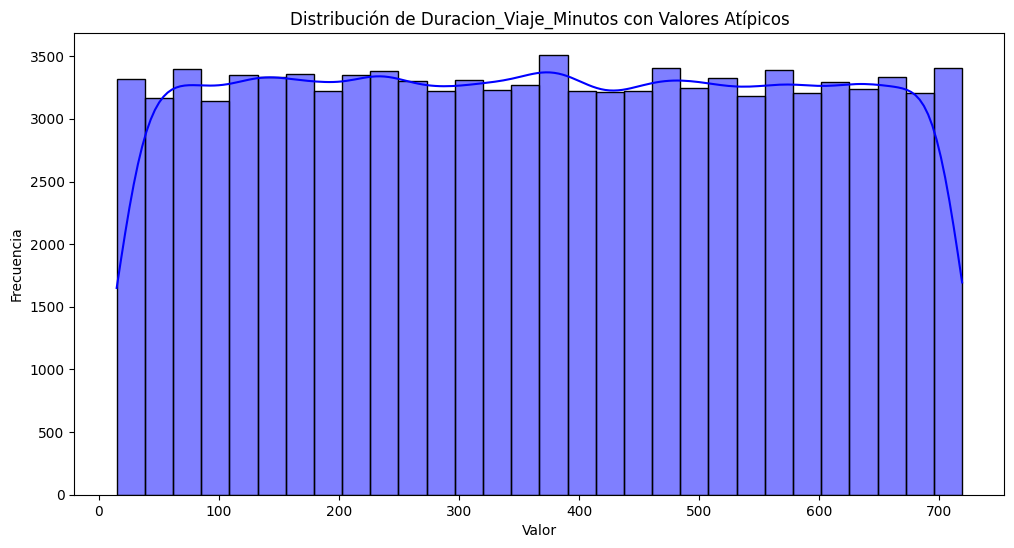

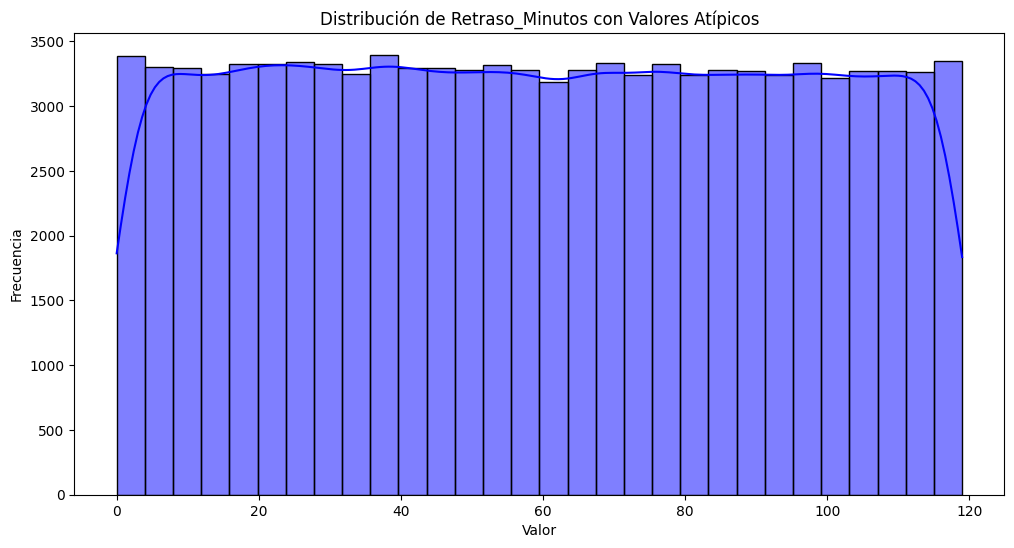

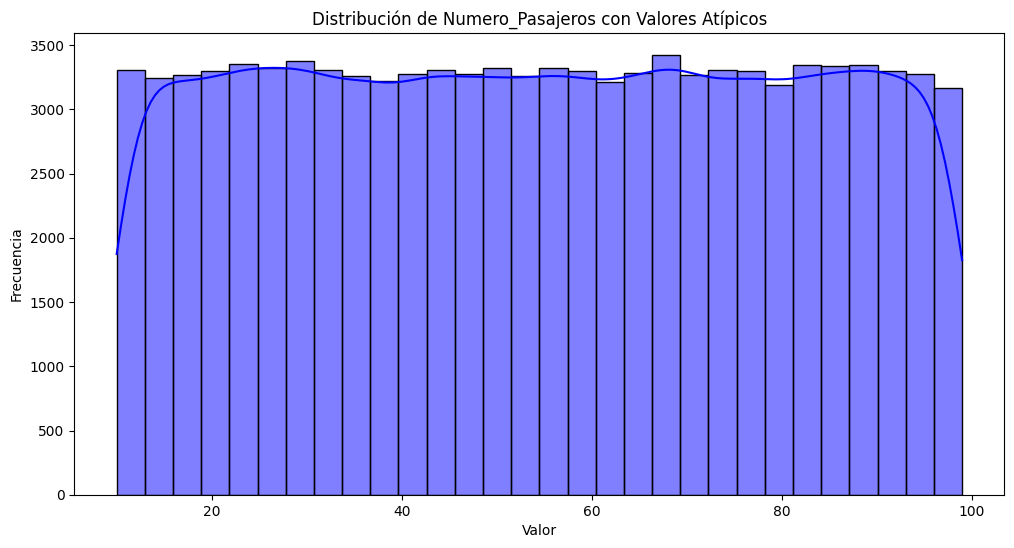

In [8]:
# Convertir las columnas a numéricas (en caso de que haya datos no numéricos)
df['Duracion_Viaje_Minutos'] = pd.to_numeric(df['Duracion_Viaje_Minutos'], errors='coerce')
df['Retraso_Minutos'] = pd.to_numeric(df['Retraso_Minutos'], errors='coerce')
df['Numero_Pasajeros'] = pd.to_numeric(df['Numero_Pasajeros'], errors='coerce')

# Eliminamos las filas con valores nulos
df.dropna(subset=['Numero_Pasajeros','Duracion_Viaje_Minutos', 'Retraso_Minutos'], inplace=True)

# Calcular el primer y tercer cuartil y determinar los valores atípicos
def find_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

outliers_duracion = find_outliers_iqr(df['Duracion_Viaje_Minutos'])
outliers_retraso = find_outliers_iqr(df['Retraso_Minutos'])
outliers_pasajeros = find_outliers_iqr(df['Numero_Pasajeros'])

# Visualizamos la distribución con un histograma y marcamos los valores atípicos. Como hemos dicho los datos no tienen sentido.
def plot_distribution_with_outliers(data, outliers, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(data, kde=True, color='blue', bins=30)
    for outlier in outliers:
        plt.axvline(outlier, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.show()

plot_distribution_with_outliers(df['Duracion_Viaje_Minutos'], outliers_duracion, 'Distribución de Duracion_Viaje_Minutos con Valores Atípicos')
plot_distribution_with_outliers(df['Retraso_Minutos'], outliers_retraso, 'Distribución de Retraso_Minutos con Valores Atípicos')
plot_distribution_with_outliers(df['Numero_Pasajeros'], outliers_retraso, 'Distribución de Numero_Pasajeros con Valores Atípicos')

In [9]:
#Valores nulos hay en las columnas del dataframe
print(df.isnull().sum())

Fecha                     0
Ruta                      0
Numero_Pasajeros          0
Duracion_Viaje_Minutos    0
Retraso_Minutos           0
Tipo_Transporte           0
Region                    0
Dia_Semana                0
dtype: int64


In [10]:
#Ahora vamos a reemplazar los valores de Dia_Semana por su equivalencia en español. Truncamos las líneas de código para que se ejecute más rápidamente según la convención Python

df['Dia_Semana'] = df['Dia_Semana'].replace('Sunday', 'Domingo').replace('Monday', 'Lunes')\
.replace('Tuesday', 'Martes').replace('Wednesday', 'Miércoles').replace('Thursday', 'Jueves')\
.replace('Friday', 'Viernes').replace('Saturday', 'Sábado')

print(df['Dia_Semana'].unique())

['Domingo' 'Lunes' 'Martes' 'Miércoles' 'Jueves' 'Viernes' 'Sábado']


In [11]:
#Analizando como quedan las columnas numéricas: media, minimo, percentil 25, mediana, percentil 75, máximo y desviación típica
print(df.describe())

       Numero_Pasajeros  Duracion_Viaje_Minutos  Retraso_Minutos
count      98766.000000            98766.000000     98766.000000
mean          54.460442              366.863668        59.328676
std           25.956173              203.283482        34.688021
min           10.000000               15.000000         0.000000
25%           32.000000              191.000000        29.000000
50%           54.000000              367.000000        59.000000
75%           77.000000              543.000000        89.000000
max           99.000000              719.000000       119.000000


In [12]:
# Calcular la correlación entre las dos columnas
correlation = df['Duracion_Viaje_Minutos'].corr(df['Retraso_Minutos'])

# Mostrar el resultado
print(f"La correlación entre Duracion_Viaje_Minutos y Retraso_Minutos es: {correlation}")

La correlación entre Duracion_Viaje_Minutos y Retraso_Minutos es: 0.0032777547314802973


In [13]:
#Convirtiendo la columnas del dataframe al tipo de datos que necesitaremos para crear nuestra base de datos SQLite. 
# #Fecha se tiene que quedar como tipo object porque si no no podremos insertar los valores en la base de datos.

df['Fecha'] = pd.to_datetime(df['Fecha']).dt.strftime('%Y-%m-%d')
df['Ruta'] = df['Ruta'].astype(str)
df['Numero_Pasajeros'] = df['Numero_Pasajeros'].astype(int)
df['Duracion_Viaje_Minutos'] = df['Duracion_Viaje_Minutos'].astype(int)
df['Tipo_Transporte'] = df['Tipo_Transporte'].astype(str)
df['Region'] = df['Region'].astype(str)
df['Dia_Semana'] = df['Dia_Semana'].astype(str)
print("\nDataFrame después de cambiar el tipo de datos")
print(df.dtypes)



DataFrame después de cambiar el tipo de datos
Fecha                     object
Ruta                      object
Numero_Pasajeros           int32
Duracion_Viaje_Minutos     int32
Retraso_Minutos            int64
Tipo_Transporte           object
Region                    object
Dia_Semana                object
dtype: object


In [14]:
#Empezamos a crear dimensiones que nos servirán para montar nuestro modelo en estrella en PowerBi
# Vamos a crear una dimension Dim_Calendar que añadiremos luego a la Base de datos

Dim_Calendar = df['Fecha'].unique().tolist()
Dim_Calendar = pd.DataFrame(Dim_Calendar)
Dim_Calendar['ID'] = range(1, len(Dim_Calendar) + 1)

print(Dim_Calendar)

             0  ID
0   2023-01-01   1
1   2023-01-02   2
2   2023-01-03   3
3   2023-01-04   4
4   2023-01-05   5
..         ...  ..
65  2023-03-07  66
66  2023-03-08  67
67  2023-03-09  68
68  2023-03-10  69
69  2023-03-11  70

[70 rows x 2 columns]


In [15]:
#Ahora hacemos lo mismo para el resto de dimensions siguiendo con la siguiente que es 'Ruta'

Dim_Ruta = df['Ruta'].unique().tolist()
Dim_Ruta = pd.DataFrame(Dim_Ruta)
Dim_Ruta['ID'] = range(1, len(Dim_Ruta) + 1)


print(Dim_Ruta)

                      0  ID
0      Malaga - Sevilla   1
1     Madrid - Zaragoza   2
2      Sevilla - Madrid   3
3       Madrid - Malaga   4
4    Madrid - Barcelona   5
5       Bilbao - Madrid   6
6    Valencia - Sevilla   7
7  Barcelona - Valencia   8
8  Zaragoza - Barcelona   9
9    Barcelona - Bilbao  10


In [16]:
#Seguimos con el Tipo de Transporte

Dim_Tipo_Transporte = df['Tipo_Transporte'].unique().tolist()
Dim_Tipo_Transporte = pd.DataFrame(Dim_Tipo_Transporte)
Dim_Tipo_Transporte['ID'] = range(1, len(Dim_Tipo_Transporte) + 1)

print(Dim_Tipo_Transporte)

         0  ID
0     Tren   1
1  Autobús   2
2    Metro   3
3  Tranvía   4


In [17]:
#Seguimos con la Región

Dim_Region = df['Region'].unique().tolist()
Dim_Region = pd.DataFrame(Dim_Region)
Dim_Region['ID'] = range(1, len(Dim_Region) + 1)

print(Dim_Region)

           0  ID
0  Barcelona   1
1     Madrid   2
2     Malaga   3
3    Sevilla   4
4   Valencia   5
5   Zaragoza   6
6     Bilbao   7


In [18]:
#Y finalizamos con Dia_Semana para tener todos los dataframes que luego insertaremos como tablas de dimensiones en nuestra base de datos.

#print(df['Dia_Semana'])
Dim_Dia_Semana = df['Dia_Semana'].unique().tolist()
Dim_Dia_Semana = pd.DataFrame(Dim_Dia_Semana)
Dim_Dia_Semana['ID'] = range(1, len(Dim_Dia_Semana) + 1)

print(Dim_Dia_Semana)

           0  ID
0    Domingo   1
1      Lunes   2
2     Martes   3
3  Miércoles   4
4     Jueves   5
5    Viernes   6
6     Sábado   7


In [19]:
# Renombramos las columnas de los DataFrames de dimensiones
Dim_Calendar.columns = ['Fecha', 'ID']
Dim_Ruta.columns = ['Ruta', 'ID']
Dim_Tipo_Transporte.columns = ['Tipo_Transporte', 'ID']
Dim_Region.columns = ['Region', 'ID']
Dim_Dia_Semana.columns = ['Dia_Semana', 'ID']

# Creamos un diccionario de mapeo para cada Dimensión
mapping_dicts = {
    'Fecha': Dim_Calendar.set_index('Fecha')['ID'].to_dict(),
    'Ruta': Dim_Ruta.set_index('Ruta')['ID'].to_dict(),
    'Tipo_Transporte': Dim_Tipo_Transporte.set_index('Tipo_Transporte')['ID'].to_dict(),
    'Region': Dim_Region.set_index('Region')['ID'].to_dict(),
    'Dia_Semana': Dim_Dia_Semana.set_index('Dia_Semana')['ID'].to_dict()
}

# Reemplazamos los valores en df usando los diccionarios de mapeo
df['Fecha_ID'] = df['Fecha'].map(mapping_dicts['Fecha'])
df['Ruta_ID'] = df['Ruta'].map(mapping_dicts['Ruta'])
df['Tipo_Transporte_ID'] = df['Tipo_Transporte'].map(mapping_dicts['Tipo_Transporte'])
df['Region_ID'] = df['Region'].map(mapping_dicts['Region'])
df['Dia_Semana_ID'] = df['Dia_Semana'].map(mapping_dicts['Dia_Semana'])

print("DataFrame df después de mapear los valores:")
print(df['Region_ID'])


DataFrame df después de mapear los valores:
ID_Viaje
2      1
3      2
4      3
5      4
6      1
      ..
96     5
97     3
98     3
99     7
100    1
Name: Region_ID, Length: 98766, dtype: int64


In [20]:
#Vamos a encerrar en listas los valores para las columnas de las tablas de nuestra base de datos.

fechas = df['Fecha'].tolist()
rutas = df['Ruta'].tolist()
numero_pasajeros = df['Numero_Pasajeros'].tolist()
duracion_viaje_minutos = df['Duracion_Viaje_Minutos'].tolist()
retraso_minutos = df['Retraso_Minutos'].tolist()
tipo_transporte = df['Tipo_Transporte'].tolist()
region = df['Region'].tolist()
dia_semana = df['Dia_Semana'].tolist()
idfactcalendar = df['Fecha_ID'].tolist()
idfactruta = df['Ruta_ID'].tolist()
idfacttipotransporte = df['Tipo_Transporte_ID'].tolist()
idfactregion = df['Region_ID'].tolist()
idfactDiaSemana = df['Dia_Semana_ID'].tolist()
fechacalendar = Dim_Calendar['Fecha'].tolist()
IDCalendar = Dim_Calendar['ID'].tolist()
Rutadimruta = Dim_Ruta['Ruta'].tolist()
IDRuta = Dim_Ruta['ID'].tolist()
Tipo_transportedimtipo_transporte = Dim_Tipo_Transporte['Tipo_Transporte'].tolist()
IDtipo_transporte = Dim_Tipo_Transporte['ID'].tolist()
Regiondimregion = Dim_Region['Region'].tolist()
IDRegion = Dim_Region['ID'].tolist()
Dia_semanadimdia_semana = Dim_Dia_Semana['Dia_Semana'].tolist()
IDDia_Semana = Dim_Dia_Semana['ID'].to_list()


# Creamos a una base de datos SQLite
conn = sqlite3.connect('transporte_publico.db')
c = conn.cursor()

# Creamos la tabla FACT_transporte_publico
c.execute('''
    CREATE TABLE IF NOT EXISTS FACT_transporte_publico (
        Fecha TIMESTAMP,
        Ruta TEXT,
        Numero_Pasajeros INTEGER,
        Duracion_Viaje_Minutos INTEGER,
        Retraso_Minutos INTEGER,
        Tipo_Transporte TEXT,
        Region TEXT,
        Dia_Semana TEXT,
        ID_Fecha INTEGER,
        ID_Ruta INTEGER,
        ID_Tipo_Transporte INTEGER,
        ID_Region INTEGER,
        ID_Dia_Semana INTEGER
    )
''')

# Creamos la tabla Dim_Calendar
c.execute('''
    CREATE TABLE IF NOT EXISTS Dim_Calendar (
        Fecha TIMESTAMP,
        ID INTEGER
    )
''')

# Creamos la tabla Dim_Ruta
c.execute('''
    CREATE TABLE IF NOT EXISTS Dim_Ruta (
        Ruta TEXT,
        ID INTEGER
    )
''')

# Creamos la tabla Dim_Tipo_Transporte
c.execute('''
    CREATE TABLE IF NOT EXISTS Dim_Tipo_Transporte (
        Tipo_Transporte TEXT,
        ID INTEGER
    )
''')

# Creamos la tabla Dim_Region
c.execute('''
    CREATE TABLE IF NOT EXISTS Dim_Region (
        Region TEXT,
        ID INTEGER
    )
''')

# Creamos la tabla Dim_Dia_Semana
c.execute('''
    CREATE TABLE IF NOT EXISTS Dim_Dia_Semana (
        Dia_Semana TEXT,
        ID INTEGER
    )
''')

# Insertamos los datos en la tabla FACT_transporte_publico
for i in range(len(fechas)):
    c.execute('''
        INSERT INTO FACT_transporte_publico (Fecha, Ruta, Numero_Pasajeros, Duracion_Viaje_Minutos, Retraso_Minutos, 
        Tipo_Transporte, Region, Dia_Semana, ID_Fecha, ID_Ruta, ID_Tipo_Transporte, ID_Region, ID_Dia_Semana)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (fechas[i], rutas[i], numero_pasajeros[i], duracion_viaje_minutos[i], retraso_minutos[i], tipo_transporte[i], 
          region[i], dia_semana[i], idfactcalendar[i], idfactruta[i], idfacttipotransporte[i], idfactregion[i], idfactDiaSemana[i]))

# Insertamos los datos en la Dim_Calendar
for i in range(len(IDCalendar)):
    c.execute('''
        INSERT INTO Dim_Calendar (Fecha, ID)
        VALUES (?, ?)
    ''', (fechacalendar[i], IDCalendar[i]))

# Insertamos los datos en la Dim_Ruta
for i in range(len(IDRuta)):
    c.execute('''
        INSERT INTO Dim_Ruta (Ruta, ID)
        VALUES (?, ?)
    ''', (Rutadimruta[i], IDRuta[i]))

# Insertamos los datos en la Dim_Tipo_Transporte
for i in range(len(IDtipo_transporte)):
    c.execute('''
        INSERT INTO Dim_Tipo_Transporte (Tipo_Transporte, ID)
        VALUES (?, ?)
    ''', (Tipo_transportedimtipo_transporte[i], IDtipo_transporte[i]))

# Insertamos los datos en la Dim_Region
for i in range(len(IDRegion)):
    c.execute('''
        INSERT INTO Dim_Region (Region, ID)
        VALUES (?, ?)
    ''', (Regiondimregion[i], IDRegion[i]))

# Insertamos los datos en la Dim_Dia_Semana
for i in range(len(IDDia_Semana)):
    c.execute('''
        INSERT INTO Dim_Dia_Semana (Dia_Semana, ID)
        VALUES (?, ?)
    ''', (Dia_semanadimdia_semana[i], IDDia_Semana[i]))

# Confirmamos los cambios y cerrar la conexión
conn.commit()
conn.close()

In [22]:
# Hagamos una pequeña comprobación para ver cómo queda nuestra tabla de hechos en la base de datos SQLite
#Listo. Ya podemos conectarnos con PowerBi a nuestra base de datos SQLite
conn = sqlite3.connect('transporte_publico.db')
c = conn.cursor()

# Consultar los datos
query = "SELECT * FROM FACT_transporte_publico"
c.execute(query)

# Obtener los resultados
rows = c.fetchall()

# Convertir los resultados a un DataFrame de pandas para mejor visualización
df_resultado = pd.DataFrame(rows, columns=[desc[0] for desc in c.description])

# Mostrar los resultados
print(df_resultado)

# Cerrar la conexión
conn.close()


            Fecha                Ruta  Numero_Pasajeros  \
0      2023-01-01    Malaga - Sevilla                99   
1      2023-01-01   Madrid - Zaragoza                10   
2      2023-01-01    Sevilla - Madrid                96   
3      2023-01-01     Madrid - Malaga                22   
4      2023-01-01   Madrid - Zaragoza                41   
...           ...                 ...               ...   
98761  2023-01-01    Sevilla - Madrid                85   
98762  2023-01-01  Barcelona - Bilbao                65   
98763  2023-01-01    Malaga - Sevilla                65   
98764  2023-01-01  Madrid - Barcelona                41   
98765  2023-01-01  Madrid - Barcelona                42   

       Duracion_Viaje_Minutos  Retraso_Minutos Tipo_Transporte     Region  \
0                         192               58            Tren  Barcelona   
1                          94              119         Autobús     Madrid   
2                         650                2           Met